In [7]:
import random
import math
import numpy as np
import pandas as pd
type(np.int32(np.atleast_1d(np.int32(0))))
from operator import attrgetter
import matplotlib.pyplot as plt
#from IPython.display import clear_output
print('ok')

ok


In [38]:
wavedate=pd.read_csv("BLUE-JAY_ver1.csv", encoding="utf_8",engine="python")#
wavedata=wavedate.values[:,16:25*36+16]
estimated_parameters=pd.read_csv("esti_BLUE-JAY_ver1.csv", encoding="shift_jis",engine="python")#
esti_para=estimated_parameters.values
GA_inference=pd.read_csv("GA_for_BLUE-JAY_2峰.csv", encoding="utf_8",engine="python")#
GA=GA_inference.values[:,0:10]

freq=np.array([0.0445953,0.0486315,0.053033,0.0578329,0.0630672,0.0687753,0.075,0.0817881,
               0.0891906,0.097263,0.106066,0.1156658,0.1261345,0.1375506,0.15,0.1635762,0.1783811,
               0.194526,0.2121321,0.2313317,0.252269,0.2751013,0.3000001,0.3271524,0.3567623])
range_max=1.5
range_min=0.5
n_gene   = 82   # The number of genes.
n_ind    = 50  #the number of individuals in a population.
CXPB     = 0.85   # The probability of crossover.
MUTPB    = 1.0   # The probability of individdual mutation.
NGEN     = 4000   # The number of generation loop.
n_parents=2     #非復元抽出の個体数
MUTINDPB = 0.0050  # The probability of gene mutation.
CXPB_MAX =0.900   #交叉率の最大値
CXPB_MIN =0.200   #交叉率の最小値
M_MAX    =0.1#10.0/n_gene  #突然変異率の最大値
M_MIN    =0.01#1.0/n_gene/2  #突然変異率の最小値
f        =15
print(np.shape((wavedata)))
print(np.shape((esti_para)))

(7000, 900)
(7000, 13)


In [33]:
class Individual(np.ndarray):
    """Container of a individual."""
    fitness = None
    
    def __new__(cls, a):
        return np.asarray(a).view(cls)

def create_ind(n_gene,parameters):
    Hv_1,cos_1,sin_1,lambda_1,omega_1=parameters[0],parameters[1],parameters[2],parameters[3],parameters[4]
    Hv_2,cos_2,sin_2,lambda_2,omega_2=parameters[5],parameters[6],parameters[7],parameters[8],parameters[9]
    """Create a individual."""
    ind=np.zeros(n_gene)
    
    Hv_1 = Hv_1*np.random.uniform(0.7,1.3)
    Hv_1 = Hv_1 if Hv_1 <= 10.23 else 10.23
    Hv_1 = Hv_1 if Hv_1 >=0.01 else 0.01
    Hv_1='{:09b}'.format(int((Hv_1-0.01)/0.020))
    
    lambda_1 =lambda_1*np.random.uniform(0.6,1.4)
    lambda_1 =lambda_1 if lambda_1 <= 7.675 else 7.675#0.01+0.015*np.sum([ind[i+a]*2**i for i in range(8,-1,-1)])#0.01<=H<=7.675
    lambda_1 =lambda_1 if lambda_1 >= 0.01 else 0.01
    lambda_1='{:09b}'.format(int((lambda_1-0.01)/0.015))
    
    theta1  =np.arctan2(sin_1,cos_1)*180/np.pi+np.random.uniform(-10,10)
    cos_1   ='{:08b}'.format(int((np.cos(theta1*np.pi/180)+1)/2*255))#2/255*np.sum([ind[i+a]*2**i for i in range(7,-1,-1)])-1
    sin_1   ='{:08b}'.format(int((np.sin(theta1*np.pi/180)+1)/2*255))#2/255*np.sum([ind[i+a]*2**i for i in range(7,-1,-1)])-1
    
    omega_1 = omega_1*np.random.uniform(0.9,1.1)
    omega_1 = omega_1 if omega_1 <= 2.255 else 2.255
    omega_1 = omega_1 if omega_1 >= 0.35 else 0.35
    omega_1  ='{:07b}'.format(int((omega_1-0.35)/0.015))#0.35+0.015*np.sum([ind[i+a]*2**i for i in range(6,-1,-1)])#0.35<=omega<=2.255
    
    """2峰目"""
    Hv_2 = Hv_2*np.random.uniform(0.5,1.5)
    Hv_2 = Hv_2 if Hv_2 <= 10.22 else 10.22#0<=H<=10.22
    Hv_2='{:09b}'.format(int(Hv_2/0.020))
    
    lambda_2 =lambda_2*np.random.uniform(0.6,1.4)
    lambda_2 =lambda_2 if lambda_2 <= 7.675 else 7.675
    lambda_2 =lambda_2 if lambda_2 >= 0.01 else 0.01
    lambda_2='{:09b}'.format(int((lambda_2-0.01)/0.015))
    
    theta2  =np.arctan2(sin_2,cos_2)*180/np.pi+np.random.uniform(-60,60)
    cos_2   ='{:08b}'.format(int((np.cos(theta2*np.pi/180)+1)/2*255))
    sin_2   ='{:08b}'.format(int((np.sin(theta2*np.pi/180)+1)/2*255))
    
    omega_2 = omega_2*np.random.uniform(0.8,1.2)
    omega_2 = omega_2 if omega_2 <= 2.255 else 2.255
    omega_2 = omega_2 if omega_2 >= 0.35 else 0.35
    omega_2  ='{:07b}'.format(int((omega_2-0.35)/0.015))
    
    for i in range(n_gene):
        ind[i]=int((Hv_1+lambda_1+cos_1+sin_1+omega_1+Hv_2+lambda_2+cos_2+sin_2+omega_2)[i])
    
    return Individual(ind)#Individual([np.random.randint(0,2) for i in range(n_gene)])

def create_pop(n_ind, n_gene):
    """Create a population."""
    pop = []
    for i in range(n_ind):
        ind = create_ind(n_gene,parameters)
        pop.append(ind)
    return pop

def set_fitness(eval_func, pop):
    """Set fitnesses of each individual in a population."""
    for k, fit in zip(range(len(pop)), map(eval_func, pop)):
        pop[k].fitness = fit


def spectrum(Hv_1,theta_1,lambda_1,omega_1,s_1,theta_func,omega):
    #theta_1=np.arctan2(sin1,cos1)*180/np.pi
    spectrum_11=0.250*((4.0*lambda_1+1.0)/4.0*omega_1**4.0)**lambda_1
    spectrum_12=math.gamma(lambda_1)
    spectrum_16=Hv_1**2.0
    spectrum_13=omega**(4.0*lambda_1+1.0)
    spectrum_14=2.0**(2.0*s_1-1.0)*(math.gamma(s_1+1.0))**2.0/math.pi/math.gamma(2.0*s_1+1.0)
    spectrum_15=abs((math.cos((theta_func-theta_1)/2.0*math.pi/180.0)))**(2.0*s_1)*math.exp(-(4.0*lambda_1+1.0)/4.0*(omega_1/omega)**4.0)
    #spectrum_1=spectrum_11/spectrum_13*spectrum_14*spectrum_15*spectrum_16/spectrum_12
    return spectrum_11/spectrum_13*spectrum_14*spectrum_15*spectrum_16/spectrum_12


def evalOneMax(ind):
    """Objective function."""
    errorfunc=0.0
    H1,cos1,sin1,lambda1,omega1,H2,cos2,sin2,lambda2,omega2 = get_parameter_from_ind(ind)
    S_max1=def_S_max(H1,omega1)
    S_max2=def_S_max(H2,omega2)
   
    for i in range(25):
        omega=freq[i]*2*math.pi
        
        """1峰目"""
        if omega<=omega1:
            s_1=(S_max1*omega**5/omega1**5)
        else:
            s_1=(S_max1*omega**(-2.5)/omega1**(-2.5))                           
 
        """2峰目"""
        if omega<=omega2:
            s_2=(S_max2*omega**5/omega2**5)
        else:
            s_2=(S_max2*omega**(-2.5)/omega2**(-2.5))  
        
        for j in range(36):              
            func1=spectrum(H1,np.arctan2(sin1,cos1)*180/np.pi,lambda1,omega1,s_1,j*10,omega)
            func2=spectrum(H2,np.arctan2(sin2,cos2)*180/np.pi,lambda2,omega2,s_2,j*10,omega)
            
            errorfunc +=(seastate[36*i+j]-2*math.pi*(func1+func2))**2
    return errorfunc

def adjustrating(C_p,M_p,CXPB_MAX,CXPB_MIN,M_MAX,M_MIN,f,f_max,fitness_mean):
    cross_para = 1.0/f-1/abs(f_max-fitness_mean)
    if (C_p*(1+cross_para))<=CXPB_MIN:
        C_p = CXPB_MIN
    else:
        if (C_p*(1+cross_para))<=CXPB_MAX:
            C_p = C_p*(1+cross_para)
        else:
            C_p = CXPB_MAX       
                                  
    M_para = 1/abs(f_max-fitness_mean) - 1/f
    if (M_p*(1+M_para))<=M_MIN:
        M_p = M_MIN
    else:
        if (M_p*(1+M_para))<=M_MAX:
            M_p = M_p*(1+M_para)
        else:
            M_p = M_MAX
         
    return  C_p,M_p

def randomselection(n_ind,pop,n_parents):
    chosen=[]    
    for i in range(n_parents):
        idx=random.randrange(0, n_ind-i)
        chosen.append(pop[idx])
        pop.pop(idx)
    return chosen,pop
    """chosen = []   
    eve1=random.randrange(0, n_ind, 2)
    odd1=random.randrange(1, n_ind, 2)
    chosen.append(pop[eve1])
    chosen.append(pop[odd1])
    if eve1>odd1:
        pop.pop(eve1)
        pop.pop(odd1)
    else:
        pop.pop(odd1)
        pop.pop(eve1) 
    return chosen,pop"""


def tournament(pop, n_ind, tournsize):
    """#Selection function."""
    chosen = []    
    for i in range(n_ind):
        aspirants = [random.choice(pop) for j in range(tournsize)]
        chosen.append(min(aspirants, key=attrgetter("fitness")))
    return chosen

def roulette(pop,C_max):
    """Selection function."""
    chosen=[]
    fitness_sum=0.0
    for i in range(len(pop)):
        fitness_sum += C_max- pop[i].fitness
        
    sigma_fitness = 0.0
    s = random.random()*fitness_sum
    for i in range(len(pop)):
        sigma_fitness += C_max-pop[i].fitness
        if (sigma_fitness)>=s:
            chosen.append(pop[i])
            break
    #chosens=chosen[:]
    #print("chosens"+str(len(chosens)))
    return chosen

def cxTwoPointCopy(ind1, ind2):
    """Crossover function."""
    size = len(ind1)
    tmp1 = ind1.copy()
    tmp2 = ind2.copy()
    cxpoint1 = random.randint(1, size)
    cxpoint2 = random.randint(1, size-1)
    if cxpoint2 >= cxpoint1:
        cxpoint2 += 1
    else: # Swap the two cx points
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1
    tmp1[cxpoint1:cxpoint2], tmp2[cxpoint1:cxpoint2] = tmp2[cxpoint1:cxpoint2].copy(), tmp1[cxpoint1:cxpoint2].copy()
    return tmp1, tmp2

def evalchild(offspring,n_ind):
    fit_mean = 0.0
    fit_var  = 0.0
    for i in range(n_ind):
        fit_mean += offspring[i].fitness/n_ind
    for k in range(n_ind):
        fit_var += (offspring[k].fitness - fit_mean)**2/n_ind
    return fit_mean, fit_var

def mutFlipBit(ind, indpb):
    """Mutation function."""
    tmp = ind.copy()
    for i in range(len(ind)):
        if random.random() < indpb:
            tmp[i] = type(ind[i])(not ind[i])
    return tmp

def keisan(n_ind,pop):
    Ex=0.0
    #Var=0.0
    for i in range(n_ind):
        Ex += pop[i].fitness
    #for i in range(n_ind):
        #Var += (pop[i].fitness-Ex)**2/n_ind
    return Ex#,Var
        

def get_parameter_from_ind(ind):
    """1峰目"""
    a=0
    Hv_1     =0.010+0.020*np.sum([ind[i]*2**(8-i) for i in range(9)])#0.1<=H<=10.23
    a+=9
    lambda_1 =0.01+0.015*np.sum([ind[i+a]*2**(8-i) for i in range(9)])#0.01<=H<=7.675
    a+=9
    cos_1   =2/255*np.sum([ind[i+a]*2**(7-i) for i in range(8)])-1
    a+=8
    sin_1   =2/255*np.sum([ind[i+a]*2**(7-i) for i in range(8)])-1
    a+=8
    theta_1  =np.arctan2(sin_1,cos_1)*180/np.pi
    omega_1  =0.35+0.015*np.sum([ind[i+a]*2**(6-i) for i in range(7)])#0.35<=omega<=2.255
    a+=7
    
    """2峰目"""
    Hv_2     =0.020*np.sum([ind[i+a]*2**(8-i) for i in range(9)])#0<=H<=10.22
    a+=9
    lambda_2 =0.01+0.015*np.sum([ind[i+a]*2**(8-i) for i in range(9)])#0.01<=H<=7.675
    a+=9
    cos_2   =2/255*np.sum([ind[i+a]*2**(7-i) for i in range(8)])-1
    a+=8
    sin_2   =2/255*np.sum([ind[i+a]*2**(7-i) for i in range(8)])-1
    a+=8
    theta_2  =np.arctan2(sin_2,cos_2)*180/np.pi
    omega_2  =0.35+0.015*np.sum([ind[i+a]*2**(6-i) for i in range(7)])#0.35<=omega<=2.255
    return Hv_1,cos_1,sin_1,lambda_1,omega_1,Hv_2,cos_2,sin_2,lambda_2,omega_2

def def_S_max(H,omega_m):
    HL=H/(1.56*4*math.pi**2/omega_m**2)
    """波集中度s1の周波数依存"""
    if H==0:
        S_max=0
    elif HL<0.026:
        log_10=0.4444*math.log10(HL)+0.5849
        a=10**(log_10)
        S_max=12.99*a**(-2.5)
        
    elif HL>=0.026:
        log10_gF=(0.1507-math.sqrt(0.1507**2+4*0.005882*0.8789+4*0.005882*math.log10(HL)))/(2*0.005882)
        gF=10**log10_gF
        gT=1.37*(1-1/(1+0.008*gF**(1/3))**5)
        S_max=12.99*gT**2.5
    
    if S_max >=84:
        S_max=84
    return S_max

In [58]:
SeaNum=2037#741#3893
Loss_Function=[]
for seastate in wavedata[SeaNum:SeaNum+1,:]:
    random.seed()
    print(esti_para[SeaNum][0])
    parameters= np.array([esti_para[SeaNum][0], esti_para[SeaNum][1],esti_para[SeaNum][2],esti_para[SeaNum][3],esti_para[SeaNum][4],
                          esti_para[SeaNum][6],esti_para[SeaNum][7],esti_para[SeaNum][8],esti_para[SeaNum][9],esti_para[SeaNum][10]])
    
    """ Step1 : 母集団作成."""
    pop = create_pop(n_ind, n_gene)
    set_fitness(evalOneMax, pop)  #各個体について評価
    fit_sum = keisan(n_ind,pop)  #適応度の合計値を計算
    best_ind = min(pop, key=attrgetter("fitness"))  #最良個体の適応度
    
    Hv_1,cos1,sin1,lambda_1,omega_1,Hv_2,cos2,sin2,lambda_2,omega_2=get_parameter_from_ind(best_ind) 

    # --- 世代分の繰り返し.
    for g in range(NGEN):     
        """ Step2 : 選択."""
        parents,pop = randomselection(n_ind,pop,n_parents)
        fit_sum=fit_sum-parents[0].fitness-parents[1].fitness
        children = parents.copy()
  
        """ Step3 : 交叉."""
        crossover = []
        for child1, child2 in zip(children[::2], children[1::2]):
            if random.random() < CXPB:
                child1, child2 = cxTwoPointCopy(child1, child2)
                child1.fitness = None
                child2.fitness = None
            crossover.append(child1)
            crossover.append(child2)
        children = crossover[:]


        """ Step4 : 突然変異."""
        mutant = []
        for mut in (children):
            if random.random() < MUTPB:
                mut = mutFlipBit(mut, indpb=MUTINDPB)
                mut.fitness = None
            mutant.append(mut)

        children = mutant[:]
        set_fitness(evalOneMax, children)

        
        """Step5 : 生存選択"""
        family = children+parents
        offspring = []
        
        family_sorted = sorted(family, key=attrgetter("fitness")) #ここで，誤差が小さい順に並べる
        offspring=roulette(family_sorted[1:],family_sorted[3].fitness)
        offspring+=family_sorted[:1]

        
        """ 次世代を現世代に更新."""
        pop = pop + offspring
        fit_sum = fit_sum+offspring[0].fitness+offspring[1].fitness
        fitness_mean =fit_sum/n_ind #,fit_var
        """ Print best fitness in the population."""
        best_ind = min(pop, key=attrgetter("fitness"))
        f_max = best_ind.fitness
        CXPB,MUTINDPB = adjustrating(CXPB,MUTINDPB,CXPB_MAX,CXPB_MIN,M_MAX,M_MIN,f,f_max,fitness_mean)
        
        Loss_Function.append(best_ind.fitness)
    Hv_1,cos1,sin1,lambda_1,omega_1,Hv_2,cos2,sin2,lambda_2,omega_2=get_parameter_from_ind(best_ind)
    theta_1=np.arctan2(sin1,cos1)*180/np.pi
    theta_2=np.arctan2(sin2,cos2)*180/np.pi
    if omega_1 < omega_2:
        print(str('%03.8f' %(Hv_1))+","+str('%03.8f' %(theta_1))+","+str('%03.8f' %(lambda_1))+","+str('%03.8f' %(omega_1))+",")
        print(str('%03.8f' %(Hv_2))+","+str('%03.8f' %(theta_2))+","+str('%03.8f' %(lambda_2))+","+str('%03.8f' %(omega_2))+",")
    elif omega_1 == omega_2 :
        if Hv_1 >= Hv_2 :
            print(str('%03.8f' %(Hv_1))+","+str('%03.8f' %(theta_1))+","+str('%03.8f' %(lambda_1))+","+str('%03.8f' %(omega_1))+",")
            print(str('%03.8f' %(Hv_2))+","+str('%03.8f' %(theta_2))+","+str('%03.8f' %(lambda_2))+","+str('%03.8f' %(omega_2))+",")
        else:
            print(str('%03.8f' %(Hv_2))+","+str('%03.8f' %(theta_2))+","+str('%03.8f' %(lambda_2))+","+str('%03.8f' %(omega_2))+",")
            print(str('%03.8f' %(Hv_1))+","+str('%03.8f' %(theta_1))+","+str('%03.8f' %(lambda_1))+","+str('%03.8f' %(omega_1))+",")
    else:
        print(str('%03.8f' %(Hv_2))+","+str('%03.8f' %(theta_2))+","+str('%03.8f' %(lambda_2))+","+str('%03.8f' %(omega_2))+",")
        print(str('%03.8f' %(Hv_1))+","+str('%03.8f' %(theta_1))+","+str('%03.8f' %(lambda_1))+","+str('%03.8f' %(omega_1))+",")    
    print(str('%03.8f' %(best_ind.fitness)))
    print('\n')
    SeaNum+=1
    print(str(len(wavedata))+"海象中 "+str(SeaNum)+"番目の海象で誤差は "+str(best_ind.fitness))

2.765341
2.66000000,-54.59313426,0.32500000,0.47000000,
1.95000000,-89.77531182,1.91500000,0.48500000,
345.72969582


7000海象中 2038番目の海象で誤差は 345.72969581649716


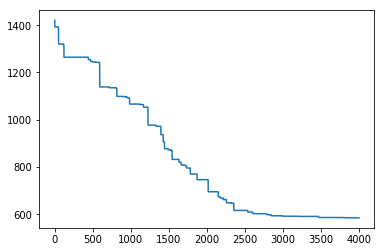

In [57]:
plt.plot(Loss_Function)
plt.show()